# Dynamic Breakpoints

## Redefine financial advicer graph (from 03_agent.ipynb)

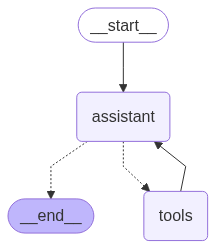

In [1]:
import requests
import yfinance as yf
from pprint import pformat
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


# Defining Tools
##################################################################################

def lookup_stock_symbol(company_name: str) -> str:
    """
    Converts a company name to its stock symbol using a financial API.

    Parameters:
        company_name (str): The full company name (e.g., 'Tesla').

    Returns:
        str: The stock symbol (e.g., 'TSLA') or an error message.
    """
    api_url = "https://www.alphavantage.co/query"
    params = {
        "function": "SYMBOL_SEARCH",
        "keywords": company_name,
        "apikey": "your_alphavantage_api_key"
    }
    
    response = requests.get(api_url, params=params)
    data = response.json()
    
    if "bestMatches" in data and data["bestMatches"]:
        return data["bestMatches"][0]["1. symbol"]
    else:
        return f"Symbol not found for {company_name}."


def fetch_stock_data_raw(stock_symbol: str) -> dict:
    """
    Fetches comprehensive stock data for a given symbol and returns it as a combined dictionary.

    Parameters:
        stock_symbol (str): The stock ticker symbol (e.g., 'TSLA').
        period (str): The period to analyze (e.g., '1mo', '3mo', '1y').

    Returns:
        dict: A dictionary combining general stock info and historical market data.
    """
    period = "1mo"
    try:
        stock = yf.Ticker(stock_symbol)

        # Retrieve general stock info and historical market data
        stock_info = stock.info  # Basic company and stock data
        stock_history = stock.history(period=period).to_dict()  # Historical OHLCV data

        # Combine both into a single dictionary
        combined_data = {
            "stock_symbol": stock_symbol,
            "info": stock_info,
            "history": stock_history
        }

        return pformat(combined_data)

    except Exception as e:
        return {"error": f"Error fetching stock data for {stock_symbol}: {str(e)}"}


# Binding tools to the LLM
##################################################################################

# Create tool bindings with additional attributes
lookup_stock = Tool.from_function(
    func=lookup_stock_symbol,
    name="lookup_stock_symbol",
    description="Converts a company name to its stock symbol using a financial API.",
    return_direct=False  # Return result to be processed by LLM
)

fetch_stock = Tool.from_function(
    func=fetch_stock_data_raw,
    name="fetch_stock_data_raw",
    description="Fetches comprehensive stock data including general info and historical market data for a given stock symbol.",
    return_direct=False
)

toolbox = [lookup_stock, fetch_stock]

# OPENAI_API_KEY environment variable must be set
simple_llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = simple_llm.bind_tools(toolbox)


# Defining Agent's node
##################################################################################

# System message
assistant_system_message = SystemMessage(content=("""
You are a professional financial assistant specializing in stock market analysis and investment strategies. 
Your role is to analyze stock data and provide **clear, decisive recommendations** that users can act on, 
whether they already hold the stock or are considering investing.

You have access to a set of tools that can provide the data you need to analyze stocks effectively. 
Use these tools to gather relevant information such as stock symbols, current prices, historical trends, 
and key financial indicators. Your goal is to leverage these resources efficiently to generate accurate, 
actionable insights for the user.

Your responses should be:
- **Concise and direct**, summarizing only the most critical insights.
- **Actionable**, offering clear guidance on whether to buy, sell, hold, or wait for better opportunities.
- **Context-aware**, considering both current holders and potential investors.
- **Free of speculation**, relying solely on factual data and trends.
- **do not forget** to provide stock name in the report, so it's clear which stock is being recommended.

### Response Format:
1. **Recommendation:** Buy, Sell, Hold, or Wait.
2. **Key Insights:** Highlight critical trends and market factors that influence the decision.
3. **Suggested Next Steps:** What the user should do based on their current position.

If the user does not specify whether they own the stock, provide recommendations for both potential buyers and current holders. Ensure your advice considers valuation, trends, and market sentiment.

Your goal is to help users make informed financial decisions quickly and confidently.
"""))

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([assistant_system_message] + state["messages"])]}


# Defining Graph
##################################################################################
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(toolbox))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Introducing an Intent Check node

In [2]:
from langgraph.errors import NodeInterrupt

def intent_check(state: MessagesState):
    user_request = state["messages"][-1].content

    financial_check_prompt = f"""
    You are an intent classifier. Your task is to determine if the user's request is specifically related to finance, investments, or financial advice.

    Evaluate the following user request:

    "{user_request}"

    If the request is about finance, investments, or financial advice, respond with "True".
    If it is unrelated to finance, respond with "False".

    Respond with only "True" or "False" and nothing else.
    """

    llm_response = llm_with_tools.invoke([HumanMessage(content=financial_check_prompt)]).content
    is_financial_question = llm_response.strip().lower() == 'true'

    if not is_financial_question:
        raise NodeInterrupt("Please ask a question related to financial advice.")

    return state

## And rebuiliding the graph

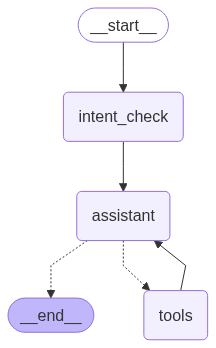

In [3]:
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("intent_check", intent_check)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(toolbox))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "intent_check")
builder.add_edge("intent_check", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Execute the graph

In [4]:
# start a new conversation
thread = {"configurable": {"thread_id": "1"}}

# define intiial user request
initial_input = {"messages": HumanMessage(content="What is the weather outside?")}

# run the graph and stream in values mode
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

What is the weather outside?


C:\Users\jenny\AppData\Local\Temp\ipykernel_37584\4216010271.py:23: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt("Please ask a question related to financial advice.")


## Check the next node to execute

In [5]:
state = graph.get_state(thread)
print(state.next)

('intent_check',)


## Check if interruption happened

In [6]:
print(state)

StateSnapshot(values={'messages': [HumanMessage(content='What is the weather outside?', additional_kwargs={}, response_metadata={}, id='dafc7115-1e6e-4371-819c-e21ff279864b')]}, next=('intent_check',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07ad19-8866-6bc0-8000-04d2f98bd84d'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-16T18:48:27.418515+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07ad19-8864-6118-bfff-d00d05824912'}}, tasks=(PregelTask(id='6beacadf-e104-6b11-aa69-5919023023e1', name='intent_check', path=('__pregel_pull', 'intent_check'), error=None, interrupts=(Interrupt(value='Please ask a question related to financial advice.', id='placeholder-id'),), state=None, result=None),), interrupts=(Interrupt(value='Please ask a question related to financial advice.', id='placeholder-id'),))


## Let's update the message

In [7]:
last_message = graph.get_state(thread).values['messages'][-1]
last_message

HumanMessage(content='What is the weather outside?', additional_kwargs={}, response_metadata={}, id='dafc7115-1e6e-4371-819c-e21ff279864b')

In [8]:
last_message.content = "Should I invest in Tesla stocks?"
last_message

HumanMessage(content='Should I invest in Tesla stocks?', additional_kwargs={}, response_metadata={}, id='dafc7115-1e6e-4371-819c-e21ff279864b')

In [9]:
graph.update_state(thread, {"messages": [last_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07ad2d-af15-6410-8001-01069254c0bc'}}

## Let's check the state

In [10]:
messages = graph.get_state(thread).values['messages']
for message in messages:
    message.pretty_print()

================================ Human Message =================================

Should I invest in Tesla stocks?


## Resuming the graph

In [11]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Should I invest in Tesla stocks?
================================ Human Message =================================

Should I invest in Tesla stocks?
================================== Ai Message ==================================
Tool Calls:
  lookup_stock_symbol (call_0GdagvMXTGOTLMncFf3jwnQ4)
 Call ID: call_0GdagvMXTGOTLMncFf3jwnQ4
  Args:
    __arg1: Tesla
================================= Tool Message =================================
Name: lookup_stock_symbol

TSLA
================================== Ai Message ==================================
Tool Calls:
  fetch_stock_data_raw (call_5Gbn7k6GIYFIo12iU3lYcGCG)
 Call ID: call_5Gbn7k6GIYFIo12iU3lYcGCG
  Args:
    __arg1: TSLA
================================= Tool Message =================================
Name: fetch_stock_data_raw

{'history': {'Close': {Timestamp('2025-07-16 00:00:00-0400', tz='America/New_York'): 321.6700134277344,
                  

# Dynamic Breakpoints via API

Let's check "financial_advisor_intent_check" graph in Studio and copy/paste the server's url!

In [13]:
from langgraph_sdk import get_client

URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

assistants = await client.assistants.search()
assistants

[{'assistant_id': '45d7f46b-abb2-5734-9fb9-b1edc76c6546',
  'graph_id': 'dev_mentor',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'dev_mentor',
  'created_at': '2025-08-15T17:20:59.259433+00:00',
  'updated_at': '2025-08-15T17:20:59.259433+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': 'ae2c32e4-0e45-57db-b449-103064dcb967',
  'graph_id': 'directive_memory_bot',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'directive_memory_bot',
  'created_at': '2025-08-15T17:20:59.156435+00:00',
  'updated_at': '2025-08-15T17:20:59.156435+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '89e77aa6-c452-5416-bd83-721b80077ae5',
  'graph_id': 'chatbot_long_term_memory',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'chatbot_long_term_memory',
  'created_at': '2025-08-15T17:20:59.046553+00:00',
  'updated_at': '2025-08-15T17:20:59.046553+00:00',
  'version'

## Start a chat with non finacial question

In [15]:
from langchain_core.messages import convert_to_messages

thread = await client.threads.create()
input_message = HumanMessage(content="How is the weather outside?")

async for event in client.runs.stream(
            thread["thread_id"], 
            assistant_id="financial_advisor_intent_check",
            input={"messages": [input_message]}, 
            stream_mode="values",
):
    messages = event.data.get('messages', None)
    if messages:
        print(convert_to_messages(messages)[-1])

content='How is the weather outside?' additional_kwargs={} response_metadata={} id='24fead9d-e5a7-47cb-af77-5bef536ad68a'


In [16]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state['next']

['intent_check']

In [17]:
current_state

{'values': {'messages': [{'content': 'How is the weather outside?',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '24fead9d-e5a7-47cb-af77-5bef536ad68a',
    'example': False}]},
 'next': ['intent_check'],
 'tasks': [{'id': '23d708ad-5d65-092a-e1a3-a6c99d29e615',
   'name': 'intent_check',
   'path': ['__pregel_pull', 'intent_check'],
   'error': None,
   'interrupts': [{'id': 'placeholder-id',
     'value': 'Please ask a question related to financial advice.'}],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'host': '127.0.0.1:2024',
  'accept-encoding': 'gzip, deflate, zstd',
  'connection': 'keep-alive',
  'user-agent': 'langgraph-sdk-py/0.2.0',
  'x-api-key': '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',
  'content-length': '286',
  'content-type': 'application/json',
  'accept': 'text/event-stream',
  'cache-control': 'no-store',
  'x-request-id': 'dbd9c230-3ebc-499b-9e5e-2625aac5a98

## Let's update the message

In [ ]:
last_message = current_state['values']['messages'][-1]
last_message

In [ ]:
last_message['content'] = "Should I invest in Tesla stocks?"
last_message

In [ ]:
await client.threads.update_state(thread['thread_id'], {"messages": last_message})

## Resume the graph

In [ ]:
async for event in client.runs.stream(
            thread["thread_id"], 
            assistant_id="financial_advisor_intent_check",
            input=None, 
            stream_mode="values",
):
    messages = event.data.get('messages', None)
    if messages:
        print(f"\n\n{convert_to_messages(messages)[-1]}")